<a href="https://colab.research.google.com/github/LCaravaggio/politext/blob/snowball/LASSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import json

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d leonardocaravaggio/base-diputados

Mounted at /content/drive
 99% 691M/698M [00:13<00:00, 69.9MB/s]
100% 698M/698M [00:14<00:00, 51.9MB/s]


In [3]:
import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [4]:
import pandas as pd
base=pd.read_csv('/content/base_formateada_snowball.csv')

<ipython-input-4-d5ff6aa7ac35>:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  base=pd.read_csv('/content/base_formateada_snowball.csv')


In [5]:
import pickle

with open('/content/vocabulary_snowball.voc', 'rb') as f:
    inter = pickle.load(f)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(2,2) ,vocabulary=inter)
matrix = cv.fit_transform(base['tokens'])

# Bases nuevas

In [8]:
# Esta celda tarda casi una hora en correr
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=30, max_iter=50, learning_method='batch', learning_offset=50.,random_state=0)
lda.fit(matrix)

LatentDirichletAllocation(learning_offset=50.0, max_iter=50, n_components=30,
                          random_state=0)

In [9]:
disc_weights=matrix*lda.components_.transpose()
base['Topic_weight']=disc_weights.argmax(axis=1)+1

In [10]:
disc_weights.shape

(334421, 30)

In [11]:
base[['apellido', 'nombre']] =base.namey.str.split(', ', expand=True)

In [12]:
column_names = [str(i) for i in range(1, 31)]

df_weights = pd.DataFrame(disc_weights, columns=column_names)

select=[ 'fecha', 'apellido', 'nombre' , 'intervention'	, 'party', 'role']
df_weights = pd.concat([base[select], df_weights], axis=1)

In [13]:
df_weights.to_csv('df_weights_snowball.csv')

In [14]:
import scipy as sp
from scipy.special import logsumexp

def frex(mod, w=0.7):
    log_beta = np.log(mod.components_)
    log_exclusivity = log_beta - logsumexp(log_beta, axis=0)
    exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
    freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
    out = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)
    return out

def ecdf(arr):
    return sp.stats.rankdata(arr, method='max') / arr.size

In [15]:
import numpy as np
frex_df=pd.DataFrame(frex(lda))
disc_frex=matrix*frex_df.transpose()

In [16]:
df_frex = pd.DataFrame(disc_frex, columns=column_names)

select=[ 'fecha', 'apellido', 'nombre' , 'intervention'	, 'party', 'role']
df_frex = pd.concat([base[select], df_frex], axis=1)

In [17]:
df_frex.to_csv('df_frex_snowball.csv')

# LASSO

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from numpy import argsort

n=20
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=50, solver='liblinear')
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)
train_matrix = cv.fit_transform(X_train['tokens'])
test_matrix = cv.transform(X_test['tokens'])
lr.fit(train_matrix,y_train)
predictions = lr.predict(test_matrix )
macro.append(f1_score(predictions,y_test, average='macro'))
weighted.append(f1_score(predictions,y_test, average='weighted'))

In [12]:
lasso=pd.DataFrame()
lasso['negativos']=cv.get_feature_names_out()[argsort(lr.coef_[0])[:20]]
lasso['positivos']=cv.get_feature_names_out()[argsort(lr.coef_[0])[-20:]]

In [20]:
lasso.to_csv('lasso_snowball.csv')

# LASSO por legislatura

In [21]:
# Relevancia de bigramas en la predicción por legislatura
tabla=[]
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']
n=20

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=50, solver='liblinear')

lasso=pd.DataFrame()

for x in legislaturas:
  base_year=base[base.legislatura==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = cv.fit_transform(X_train['tokens'])
  test_matrix = cv.transform(X_test['tokens'])
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  macro.append(f1_score(predictions,y_test, average='macro'))
  weighted.append(f1_score(predictions,y_test, average='weighted'))
  s=lr.coef_[0]
  lasso[f"Legislatura: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
  lasso[f"Legislatura: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]

In [22]:
lasso.to_csv('lasso_por_legislatura_snowball.csv')

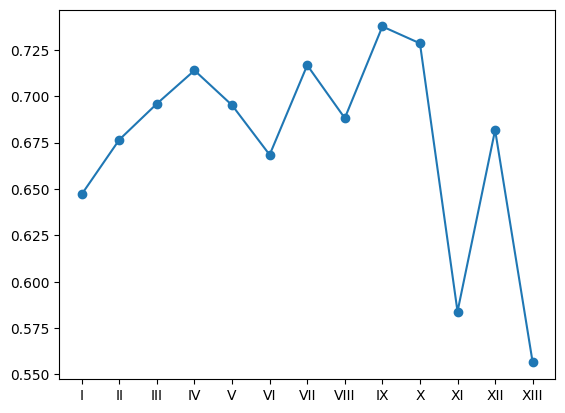

In [23]:
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.savefig('lasso_por_legislatura_snowball.png')

# LASSO por año

In [24]:
base.fecha=pd.to_datetime(base.fecha, infer_datetime_format=True)

In [25]:
# Relevancia de bigramas en la predicción por año
macro=[]
weighted=[]

nombres=cv.get_feature_names_out()

n = 20
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')


lasso=pd.DataFrame()

for x in range (1979, 2020):
  base_year=base[pd.DatetimeIndex(base.fecha).year==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = cv.fit_transform(X_train['tokens'])
  test_matrix = cv.transform(X_test['tokens'])
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  macro.append(f1_score(predictions,y_test, average='macro'))
  weighted.append(f1_score(predictions,y_test, average='weighted'))
  s = lr.coef_[0]
  lasso[f"Año: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
  lasso[f"Año: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]

In [26]:
lasso.to_csv('lasso_por_año_snowball.csv')

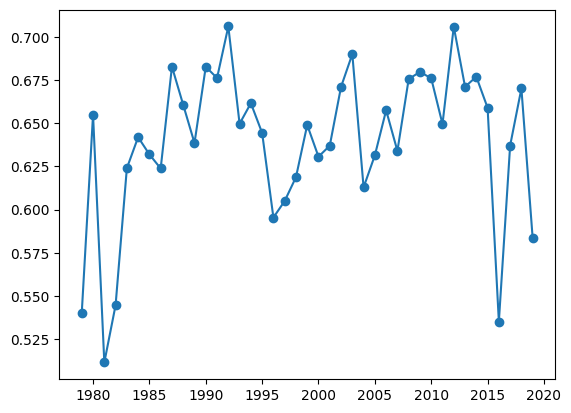

In [27]:
import matplotlib.pyplot as plt
plt.plot(range(1979,2020), macro, marker='o')
plt.savefig('lasso_por_año_snowball.png')

# LASSO por Semana

In [28]:
len((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique())

1164

In [29]:
base['semana']=pd.Series(pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).values


In [30]:
# Esta celda demora unos 25 minutos en correr
import numpy as np
lasso = pd.DataFrame(columns=[f"neg-{x}" for x in range(1, 21)] + [f"pos-{x}" for x in range(1, 21)], index=pd.Index((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str) + '-' + pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), name='semana'))
#lasso = pd.DataFrame(columns=[f"neg-{x}" for x in range(1, 21)] + [f"pos-{x}" for x in range(1, 21)], index=pd.Index(('1979-12','2019-35'), name='semana'))
macro=[]
weighted=[]

for x in lasso.index:
    try:
      base_semana = base[base['semana'] == x]
      X_train, X_test, y_train, y_test = train_test_split(base_semana.loc[:, base_semana.columns != 'party'], base_semana['party'], test_size=0.33, random_state=42)
      train_matrix = cv.fit_transform(X_train['tokens'])
      test_matrix = cv.transform(X_test['tokens'])
      lr.fit(train_matrix, y_train)
      predictions = lr.predict(test_matrix)
      s = lr.coef_[0]
      neg_features = cv.get_feature_names_out()[np.argsort(s)[:20]]
      pos_features = cv.get_feature_names_out()[np.argsort(s)[-20:]]
      lasso.loc[x, [f"neg-{i+1}" for i in range(20)]] = neg_features
      lasso.loc[x, [f"pos-{i+1}" for i in range(20)]] = pos_features

      predictions = lr.predict(test_matrix )
      macro.append(f1_score(predictions,y_test, average='macro'))
      weighted.append(f1_score(predictions,y_test, average='weighted'))
    except:
      macro.append(np.nan)
      weighted.append(np.nan)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [31]:
lasso.to_csv('lasso_por_semana_snowball.csv')

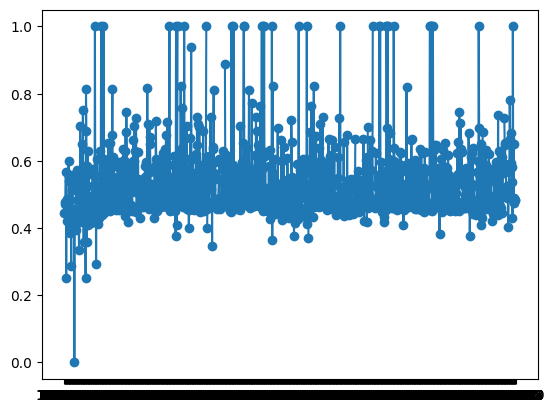

In [32]:
import matplotlib.pyplot as plt
plt.plot((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), macro, marker='o')

plt.savefig('lasso_por_semana_snowball.png')

In [33]:
lasso['macro']=macro

In [34]:
# Estas son las semanas que tienen macro==1
lasso.index[lasso['macro'] == 1]

Index(['1981-50', '1982-25', '1982-52', '1989-5', '1989-47', '1990-2',
       '1990-35', '1992-27', '2001-36', '2001-42', '2002-34', '2002-35',
       '2003-49', '2003-52', '1996-13', '1996-52', '1999-18', '2000-5',
       '2004-33', '2007-3', '2007-29', '2007-31', '2008-5', '2008-13',
       '2008-15', '2008-43', '2011-34', '2011-35', '2011-42', '2011-44',
       '2012-2', '2015-49', '2019-30'],
      dtype='object', name='semana')

In [35]:
# Una sola semana tiene macro==0
lasso.index[lasso['macro'] == 0]

Index(['1980-5'], dtype='object', name='semana')

In [36]:
base[base.semana=='1981-1']

,Unnamed: 0,orden,namex,intervention,fecha,legislatura,pleno,role,oradorx,namey,...,oradory,cataluna,estatut,inter_raw,partido,tokens,Topic_weight,apellido,nombre,semana
5387,5387,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,LLUCH MARTIN,Para turno a favor.,1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",LLUCH MARTIN,"Lluch Martín, Ernest †",...,LLUCH MARTIN,0.0,0.0,NaN,PSC-PSOE,[],1,Lluch Martín,Ernest †,1981-1
5388,5388,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,LLUUCH MARTIN,"Señor Presidente, señoras Diputadas, señores ...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",LLUUCH MARTIN,"Lluch Martín, Ernest †",...,LLUCH MARTIN,0.0,0.0,NaN,PSC-PSOE,"['señor', 'diput', 'señor', 'diput', 'maner', ...",27,Lluch Martín,Ernest †,1981-1
5389,5389,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,GARCIA-MARGALLO MARFIL,"Señor Presidente, señoras y señores Diputados...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",GARCIA-MARGALLO MARFIL,"García-Margallo y Marfil, José Manuel",...,GARCIA-MARGALLO Y MARFIL,0.0,0.0,NaN,"UCD, CP, PP","['señor', 'señor', 'diput', 'mism', 'breved', ...",11,García-Margallo y Marfil,José Manuel,1981-1
5390,5390,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,LLUCH MARTIN,"Señor Presidente, señoras Diputadas, señores ...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",LLUCH MARTIN,"Lluch Martín, Ernest †",...,LLUCH MARTIN,0.0,0.0,NaN,PSC-PSOE,"['señor', 'diput', 'señor', 'diput', 'segu', '...",27,Lluch Martín,Ernest †,1981-1
5391,5391,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,GARCIA-MARGALLO MARFIL,"Señor Presidente, señoras y señores Diputados...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",GARCIA-MARGALLO MARFIL,"García-Margallo y Marfil, José Manuel",...,GARCIA-MARGALLO Y MARFIL,0.0,0.0,NaN,"UCD, CP, PP","['señor', 'señor', 'diput', 'ratific', 'aclar'...",1,García-Margallo y Marfil,José Manuel,1981-1
5392,5392,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,BARON CRESPO,"Señor Presidente, señoras y señores Diputados...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",BARON CRESPO,"Barón Crespo, Enrique",...,BARON CRESPO,0.0,0.0,NaN,PSOE,"['señor', 'señor', 'diput', 'aprob', 'presupue...",22,Barón Crespo,Enrique,1981-1
5393,5393,ELFOCION DE MAGISTRADO DEL TRIBUNAL CONSTITUCI...,VICEPRESIDENTE (Fraile Poujade),Vamos a comenzar el escrutinio. (Pausa.) Pre...,1980-12-29,I,141.0,"VICEPRESIDENTE, VICEPRESIDENTA",FRAILE POUJADE,"Fraile Poujade, Modesto †",...,FRAILE POUJADE,0.0,0.0,NaN,"UCD, AP-PDP, CP","['comenz', 'escrutini', 'paus', 'previ', 'anun...",19,Fraile Poujade,Modesto †,1981-1


In [37]:
# Estas son las semanas en las que el macro es > 0.8
lasso.index[lasso['macro'] > 0.8]

Index(['1981-8', '1981-50', '1982-25', '1982-52', '1983-41', '1986-52',
       '1989-5', '1989-47', '1990-2', '1990-13', '1990-35', '1991-12',
       '1992-27', '1993-9', '2001-4', '2001-36', '2001-42', '2002-34',
       '2002-35', '2003-4', '2003-49', '2003-52', '1996-13', '1996-52',
       '1997-4', '1999-18', '2000-5', '1994-3', '2004-33', '2007-3', '2007-29',
       '2007-31', '2008-5', '2008-13', '2008-15', '2008-43', '2009-43',
       '2011-34', '2011-35', '2011-42', '2011-44', '2012-2', '2015-49',
       '2019-30'],
      dtype='object', name='semana')

# Asignacion de Topic por semana

In [38]:
import statistics as st
a=[]
for x in lasso.index:
      a.append(st.mode(base[base['semana'] == x]['Topic_weight']))

In [39]:
topic_semana=pd.DataFrame(lasso['macro'])

In [40]:
topic_semana['topic']=a

In [41]:
topic_semana.to_csv('topic_por_semana_snowball.csv')

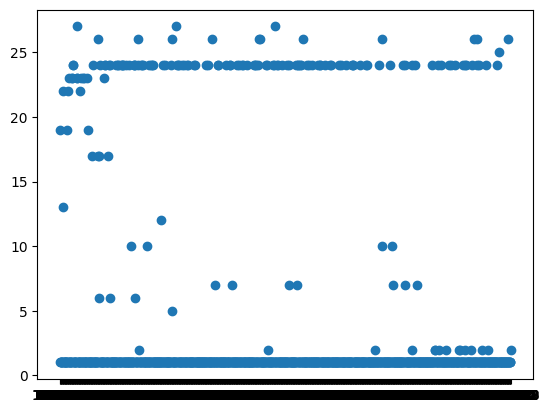

In [42]:
import matplotlib.pyplot as plt
plt.scatter((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), topic_semana['topic'], marker='o')
plt.savefig('topic_por_semana_snowball.png')

In [43]:
# Estas son las semanas en las que se habló de temas distintos al Topic 1.
topic_semana.index[topic_semana['topic'] != 1]

Index(['1979-12', '1979-22', '1979-24', '1979-45', '1979-48', '1979-50',
       '1980-11', '1980-13', '1980-15', '1980-17',
       ...
       '2016-29', '2016-33', '2016-42', '2017-3', '2017-22', '2017-34',
       '2018-21', '2018-28', '2019-21', '2019-49'],
      dtype='object', name='semana', length=175)

# Mes

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from numpy import argsort
import numpy as np

In [8]:
base['fecha'] = pd.to_datetime(base['fecha'])
base['mes'] = base['fecha'].dt.strftime('%Y-%m')

<ipython-input-8-79d7d0c85415>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  base['fecha'] = pd.to_datetime(base['fecha'])


In [9]:
meses=sorted(base.mes.unique(), key=lambda x: (int(x.split('-')[0]), int(x.split('-')[1])))

In [13]:
# Relevancia de bigramas en la predicción por mes
macro = []
weighted = []

nombres = cv.get_feature_names_out()

n = 20
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

lasso_neg = []
lasso_pos = []

lasso=pd.DataFrame()

for x in meses:
    base_mes = base[base.mes == x]
    X_train, X_test, y_train, y_test = train_test_split(
        base_mes.loc[:, base_mes.columns != 'party'],
        base_mes['party'],
        test_size=0.33,
        random_state=12
    )
    train_matrix = cv.fit_transform(X_train['tokens'])
    test_matrix = cv.transform(X_test['tokens'])
    try:
      lr.fit(train_matrix, y_train)
      predictions = lr.predict(test_matrix)
      macro.append(f1_score(predictions, y_test, average='macro'))
      weighted.append(f1_score(predictions, y_test, average='weighted'))
      s = lr.coef_[0]
      lasso[f"Mes: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
      lasso[f"Mes: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]
    except:
      lasso[f"Mes: {x} - neg"] = np.nan
      lasso[f"Mes: {x} - pos"] = np.nan
      macro.append(np.nan)

<ipython-input-13-ebd4aaa4f1d8>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lasso[f"Mes: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
<ipython-input-13-ebd4aaa4f1d8>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lasso[f"Mes: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]
<ipython-input-13-ebd4aaa4f1d8>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

In [14]:
lasso.to_csv('lasso_por_mes_snowball.csv')

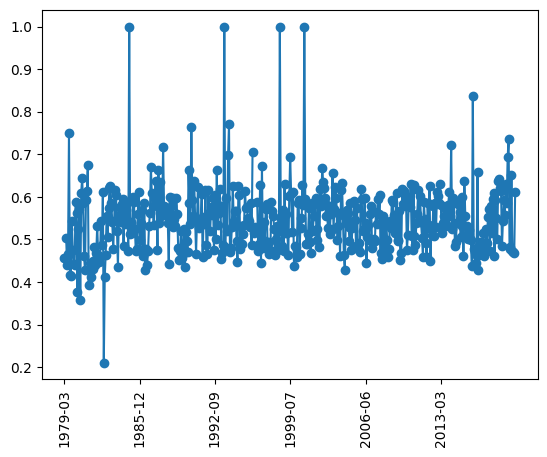

In [15]:
import matplotlib.pyplot as plt
plt.plot(meses, macro, marker='o')

selected_indices = [0, 80, 160, 240, 320, 400]
selected_labels = [meses[i] for i in selected_indices]
plt.xticks(selected_indices, selected_labels, rotation=90)

plt.savefig('lasso_por_mes_snowball.png')

# Bajada

In [53]:
from google.colab import files
files.download('df_frex_snowball.csv')
files.download('df_weights_snowball.csv')

files.download('lasso_snowball.csv')

files.download('lasso_por_legislatura_snowball.png')
files.download('lasso_por_legislatura_snowball.csv')

files.download('lasso_por_año_snowball.png')
files.download('lasso_por_año_snowball.csv')

#files.download('lasso_por_mes_snowball.png')
files.download('lasso_por_mes_snowball.csv')

files.download('topic_por_semana_snowball.png')
files.download('topic_por_semana_snowball.csv')
files.download('lasso_por_semana_snowball.png')
files.download('lasso_por_semana_snowball.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>